Make paper figures comparing the BIC statistics for (i) M31, (ii) M33, and (iii) synthetic thick-HI fits

(a) histograms of delta BIC

(b) delta BIC vs. apparent dark NHI

(c)

In [8]:
'''
Figure of the BIC for the full cube models.
'''

%matplotlib inline

from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import os
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import Projection
from scipy import ndimage as nd
from astropy.stats import histogram as astro_hist
from tqdm import tqdm
from corner import hist2d

osjoin = os.path.join

repo_path = os.path.expanduser("~/ownCloud/project_code/ThickHIFitting/")

figures_path_png = osjoin(repo_path, "figures/png")
figures_path_pdf = osjoin(repo_path, "figures/pdf")


def save_figure(fig, plot_name):
    fig.savefig(f"{figures_path_pdf}/{plot_name}.pdf")
    fig.savefig(f"{figures_path_png}/{plot_name}.png")


paths_script = os.path.join(repo_path, "paths.py")
exec(compile(open(paths_script, "rb").read(), paths_script, 'exec'))

plotstyle_script = os.path.join(repo_path, "plotting_styles.py")
exec(compile(open(plotstyle_script, "rb").read(), plotstyle_script, 'exec'))

model_script = os.path.join(repo_path, "gaussian_model.py")
exec(compile(open(model_script, "rb").read(), model_script, 'exec'))

thickHI_model_script = os.path.join(repo_path, "thickHI_model.py")
exec(compile(open(thickHI_model_script, "rb").read(),
             thickHI_model_script, 'exec'))


Load in all data products.

In [137]:
# M31

m31_cube = SpectralCube.read(fifteenA_HI_BCtaper_wEBHIS_HI_file_dict['Cube'])
print(f'Opening cube {fifteenA_HI_BCtaper_wEBHIS_HI_file_dict["Cube"]}')

m31_vels = m31_cube.spectral_axis.to(u.m / u.s)
      
del m31_cube

m31_mom0 = Projection.from_hdu(fits.open(fifteenA_HI_BCtaper_wEBHIS_HI_file_dict['Moment0'])).to(u.K * u.km / u.s)
      
m31_multigauss_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_multigaussian_gausspy_fits_neighbcheck2_nomw.fits")
# m31_multigauss_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_multigaussian_gausspy_fits_neighbcheck2.fits")
m31_multigauss_hdu = fits.open(m31_multigauss_name)

m31_ngauss = np.isfinite(m31_multigauss_hdu[0].data).sum(0) // 3

m31_thickHI_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_simplethick_HI_fits_5kms_centlimit.fits")
m31_thickHI_hdu = fits.open(m31_thickHI_name)

m31_thickHI80_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_simplethick_HI_fits_80kms_centlimit.fits")
m31_thickHI80_hdu = fits.open(m31_thickHI_name)

# Keep only where the fit parameters are valid
m31_multigauss_hdu[2].data[m31_ngauss == 0] = np.NaN

m31_multigauss_bic_proj = Projection.from_hdu(m31_multigauss_hdu[2])
      
# Split the different fit statistics
m31_thickHI_bic_proj = Projection.from_hdu(fits.PrimaryHDU(m31_thickHI_hdu[2].data[0], m31_thickHI_hdu[2].header))
m31_thickHI80_bic_proj = Projection.from_hdu(fits.PrimaryHDU(m31_thickHI80_hdu[2].data[0], m31_thickHI_hdu[2].header))
      
m31_thickHI_rchi_proj = Projection.from_hdu(fits.PrimaryHDU(m31_thickHI_hdu[2].data[2], m31_thickHI_hdu[2].header))
m31_thickHI80_rchi_proj = Projection.from_hdu(fits.PrimaryHDU(m31_thickHI80_hdu[2].data[2], m31_thickHI_hdu[2].header))
      
# Lastly, the recomputed statistics limited to where tau > 0.5
m31_modcompare_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_recomp_bic_tau_gt_0p5_5kms_centlimit.fits")
m31_modcompare_hdu = fits.open(m31_modcompare_name)
      
m31_modcompare80_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_recomp_bic_tau_gt_0p5_80kms_centlimit.fits")
m31_modcompare80_hdu = fits.open(m31_modcompare_name)
      
# Slice out to zoom into the valid data region.
spat_slice_zoom_m31 = tuple([slice(vals.min() - 10, vals.max() + 10) for vals in
                             np.where(np.isfinite(m31_multigauss_hdu[2].data))])
print(spat_slice_zoom_m31)
# Make custom slice so the array shapes are roughly the same in M33 and M31
spat_slice_zoom_m31 = (slice(105, 1709), slice(347, 1603))

Opening cube /mnt/bigdata/ekoch/M31/VLA/15A-175/HI/full_imaging_BCD_taper_0_42kms_wEBHIS/M31_15A_B_C_14A_HI_contsub_width_0_4kms.image.pbcor.EBHIS_feathered.fits
(slice(247, 1568, None), slice(338, 1611, None))


In [138]:
# M33

cube_name = fourteenB_HI_data_wGBT_path("M33_14B-088_HI.clean.image.GBT_feathered.pbcov_gt_0.5_masked.fits")

downsamp_cube_name = f"{cube_name.rstrip('.fits')}_0p42kms_K.fits"
        
m33_cube = SpectralCube.read(downsamp_cube_name)
print(f'Opening cube {downsamp_cube_name}')

m33_vels = m33_cube.spectral_axis.to(u.m / u.s)
      
del m33_cube

m33_mom0_name = "M33_14B-088_HI.clean.image.GBT_feathered.pbcov_gt_0.5_masked.moment0_Kkms.fits"
m33_mom0 = Projection.from_hdu(fits.open(fourteenB_HI_data_wGBT_path(m33_mom0_name))).to(u.K * u.km / u.s)

m33_multigauss_name = fourteenB_HI_data_wGBT_path("individ_multigaussian_gausspy_fits_neighbcheck2_nomw.fits")
# m33_multigauss_name = fourteenB_HI_data_wGBT_path("individ_multigaussian_gausspy_fits_neighbcheck2.fits")
m33_multigauss_hdu = fits.open(m33_multigauss_name)

m33_ngauss = np.isfinite(m33_multigauss_hdu[0].data).sum(0) // 3

m33_thickHI_name = fourteenB_HI_data_wGBT_path("individ_simplethick_HI_fits_5kms_centlimit.fits")
m33_thickHI_hdu = fits.open(m33_thickHI_name)

m33_thickHI80_name = fourteenB_HI_data_wGBT_path("individ_simplethick_HI_fits_80kms_centlimit.fits")
m33_thickHI80_hdu = fits.open(m33_thickHI_name)

# Keep only where the fit parameters are valid
m33_multigauss_hdu[2].data[m33_ngauss == 0] = np.NaN

m33_multigauss_bic_proj = Projection.from_hdu(m33_multigauss_hdu[2])

# Split the different fit statistics
m33_thickHI_bic_proj = Projection.from_hdu(fits.PrimaryHDU(m33_thickHI_hdu[2].data[0], m33_thickHI_hdu[2].header))
m33_thickHI80_bic_proj = Projection.from_hdu(fits.PrimaryHDU(m33_thickHI80_hdu[2].data[0], m33_thickHI_hdu[2].header))

m33_thickHI_rchi_proj = Projection.from_hdu(fits.PrimaryHDU(m33_thickHI_hdu[2].data[2], m33_thickHI_hdu[2].header))
m33_thickHI80_rchi_proj = Projection.from_hdu(fits.PrimaryHDU(m33_thickHI80_hdu[2].data[2], m33_thickHI_hdu[2].header))

# Lastly, the recomputed statistics limited to where tau > 0.5
m33_modcompare_name = fourteenB_HI_data_wGBT_path("individ_recomp_bic_tau_gt_0p5_5kms_centlimit.fits")
m33_modcompare_hdu = fits.open(m33_modcompare_name)
      
m33_modcompare80_name = fourteenB_HI_data_wGBT_path("individ_recomp_bic_tau_gt_0p5_80kms_centlimit.fits")
m33_modcompare80_hdu = fits.open(m33_modcompare_name)

# Slice out to zoom into the valid data region.
spat_slice_zoom_m33 = (slice(None), slice(None))


Opening cube /mnt/bigdata/ekoch/M33/VLA/14B-088/HI/full_imaging_wGBT/M33_14B-088_HI.clean.image.GBT_feathered.pbcov_gt_0.5_masked_0p42kms_K.fits


In [28]:
# Synthetic
# Produced from simrecovery/montecarli_thickHI_multigauss_comparison.py
from astropy.table import Table

# output_name = 'm31_synthetic_thickHI_multigauss_comparison.csv'
output_name = 'm31_synthetic_thickHI_multigauss_comparison_with_lowtau.csv'
tab = Table.read(f"../simrecovery/{output_name}")

In [12]:
def darkNHI_fraction(vels, params):
    '''
    Compute the fraction of apparent dark NHI
    
    params: Ts, sigma, Tpeak, vcent
    '''
    
    mod_thickHI = isoturbHI_simple(vels / 1000., params[0],
                                   params[1],
                                   params[2],
                                   params[3])
    
    par = np.array([params[2], params[3],
                    params[1]])
    mod_thickHI_thinlimit = multigaussian_nolmfit(vels / 1000., par)
    missing_intint = (mod_thickHI_thinlimit - mod_thickHI).sum() 
    missing_intint_frac = missing_intint / mod_thickHI_thinlimit.sum()
    
    diff_vel = np.abs(vels[1] - vels[0])
    
    return missing_intint * diff_vel, missing_intint_frac
    

In [13]:
# Compute all the dark NHI fractions

m31_darknhi = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN
m31_darknhi80 = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN

m31_darknhi_frac = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN
m31_darknhi80_frac = np.zeros_like(m31_thickHI_bic_proj.value) * np.NaN

yy, xx = np.indices(m31_darknhi.shape)
for (y, x) in tqdm(zip(yy.ravel(), xx.ravel()), total=yy.size):
    m31_darknhi[y, x], m31_darknhi_frac[y, x] = \
        darkNHI_fraction(m31_vels.value, m31_thickHI_hdu[0].data[:, y, x])
    m31_darknhi80[y, x], m31_darknhi80_frac[y, x] = \
        darkNHI_fraction(m31_vels.value, m31_thickHI80_hdu[0].data[:, y, x])
    

m33_darknhi = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN
m33_darknhi80 = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN

m33_darknhi_frac = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN
m33_darknhi80_frac = np.zeros_like(m33_thickHI_bic_proj.value) * np.NaN

yy, xx = np.indices(m33_darknhi.shape)
for (y, x) in tqdm(zip(yy.ravel(), xx.ravel()), total=yy.size):
    m33_darknhi[y, x], m33_darknhi_frac[y, x] = \
        darkNHI_fraction(m33_vels.value, m33_thickHI_hdu[0].data[:, y, x])
    m33_darknhi80[y, x], m33_darknhi80_frac[y, x] = \
        darkNHI_fraction(m33_vels.value, m33_thickHI80_hdu[0].data[:, y, x])
    

100%|██████████| 2014624/2014624 [04:51<00:00, 6922.09it/s]


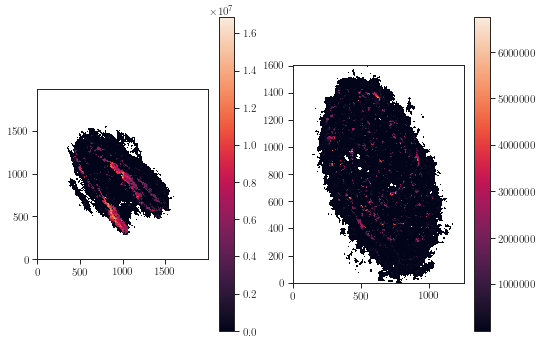

In [14]:
twocolumn_figure()

plt.subplot(121)
plt.imshow(m31_darknhi, origin='lower')
plt.colorbar()

plt.subplot(122)
plt.imshow(m33_darknhi, origin='lower')
plt.colorbar()

(b) delta BIC vs. apparent dark NHI

Text(0, 0.5, 'Apparent Dark NHI Fraction')

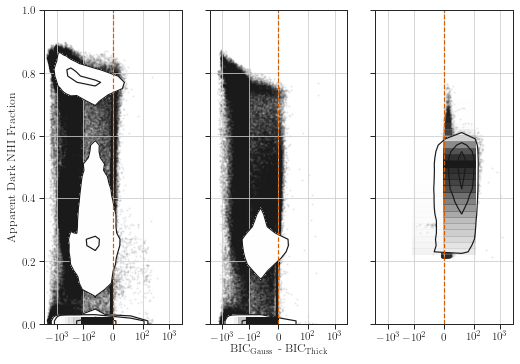

In [29]:
twocolumn_figure()


diff_bic_m31 = m31_multigauss_bic_proj - m31_thickHI_bic_proj
diff_bic_m31_zoom = diff_bic_m31[spat_slice_zoom_m31]

valids_mask_m31 = np.logical_and(np.isfinite(diff_bic_m31), m31_ngauss > 0)

diff_bic_m33 = m33_multigauss_bic_proj - m33_thickHI_bic_proj
diff_bic_m33_zoom = diff_bic_m33[spat_slice_zoom_m33]

valids_mask_m33 = np.logical_and(np.isfinite(diff_bic_m33), m33_ngauss > 0)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

# ranges = [(-2500, 500), (0.0, 1.0)]
ranges = [(-3000, 3000), (0.0, 1.0)]

hist2d(diff_bic_m31[valids_mask_m31 & np.isfinite(m31_darknhi_frac)],
       m31_darknhi_frac[valids_mask_m31 & np.isfinite(m31_darknhi_frac)],
       ax=axs[0],
       bins=50,
       range=ranges)

hist2d(diff_bic_m33[valids_mask_m33 & np.isfinite(m33_darknhi_frac)],
       m33_darknhi_frac[valids_mask_m33 & np.isfinite(m33_darknhi_frac)],
       ax=axs[1],
       bins=50,
       range=ranges)

tab_finites = np.logical_and(np.isfinite(tab['mgauss_BIC']), np.isfinite(tab['darkint_taulim']))
hist2d((tab['mgauss_BIC'] - tab['thick_BIC'])[tab_finites],
       tab['darkint_taulim'][tab_finites] / tab['optthinint_taulim'][tab_finites],
       ax=axs[2],
       bins=50,
       range=ranges)

axs[0].axvline(0., color='r', linestyle='--')
axs[1].axvline(0., color='r', linestyle='--')
axs[2].axvline(0., color='r', linestyle='--')

axs[0].set_xscale('symlog', linthreshx=100.)

[ax.grid() for ax in axs]

axs[1].set_xlabel(r"BIC$_{\rm Gauss}$ - BIC$_{\rm Thick}$")
axs[0].set_ylabel("Apparent Dark NHI Fraction")

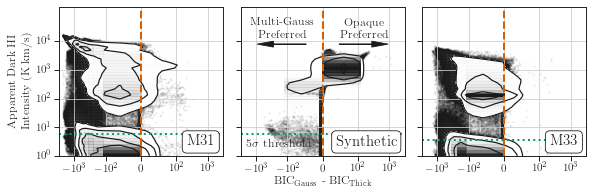

In [139]:
# twocolumn_figure()
twocolumn_twopanel_figure()


diff_bic_m31 = m31_multigauss_bic_proj - m31_thickHI_bic_proj
diff_bic_m31_zoom = diff_bic_m31[spat_slice_zoom_m31]

valids_mask_m31 = np.logical_and(np.isfinite(diff_bic_m31), m31_ngauss > 0)

diff_bic_m33 = m33_multigauss_bic_proj - m33_thickHI_bic_proj
diff_bic_m33_zoom = diff_bic_m33[spat_slice_zoom_m33]

valids_mask_m33 = np.logical_and(np.isfinite(diff_bic_m33), m33_ngauss > 0)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

# ranges = [(-2500, 500), (0.0, 8000.0)]
ranges = [(-3000, 3000), (0.0, 5.2)]
# ranges = None

hist2d(diff_bic_m31[valids_mask_m31 & np.isfinite(m31_darknhi_frac)],
       np.log10(m31_darknhi[valids_mask_m31 & np.isfinite(m31_darknhi_frac)] / 1000),
       ax=axs[0],
       bins=50,
       range=ranges)

hist2d(diff_bic_m33[valids_mask_m33 & np.isfinite(m33_darknhi_frac)],
       np.log10(m33_darknhi[valids_mask_m33 & np.isfinite(m33_darknhi_frac)] / 1000),
       ax=axs[2],
       bins=50,
       range=ranges)

tab_finites = np.logical_and(np.isfinite(tab['mgauss_BIC']), np.isfinite(tab['darkint_total']))
hist2d((tab['mgauss_BIC'] - tab['thick_BIC'])[tab_finites],
       np.log10(tab['darkint_total'][tab_finites] / 1000),
       ax=axs[1],
       bins=50,
       range=ranges)

axs[0].axvline(0., color='r', linestyle='--', linewidth=2)
axs[1].axvline(0., color='r', linestyle='--', linewidth=2)
axs[2].axvline(0., color='r', linestyle='--', linewidth=2)

# M31 5-sigma integrated intensity per channel
axs[0].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)
# M33 5-sigma integrated intensity per channel
axs[2].axhline(np.log10(5 * 0.42 * 2.4 / np.sqrt(2)), color='g', linestyle=':', linewidth=2)
# M31 noise used for synthetic tests
axs[1].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)

[ax.grid() for ax in axs]

axs[0].set_xscale('symlog', linthreshx=100.)

axs[1].set_xlabel(r"BIC$_{\rm Gauss}$ - BIC$_{\rm Thick}$")
axs[0].set_ylabel("Apparent Dark HI\nIntensity (K km/s)")

axs[0].set_yticks([0, 1, 2, 3, 4])
axs[0].set_yticklabels([r'10$^0$', r'10$^1$', r'10$^2$', r'10$^3$', r'10$^4$'])

# Make various text labels in the plots
# Labels
bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

xp = 0.95
yp = 0.05

axs[0].text(xp, yp, "M31", transform=axs[0].transAxes,
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)
axs[2].text(xp, yp, "M33", transform=axs[2].transAxes,
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)
axs[1].text(xp, yp, "Synthetic", transform=axs[1].transAxes,
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)

# BIC model preference
axs[1].text(0.25, 0.85, "Multi-Gauss\nPreferred",
            transform=axs[1].transAxes,
            horizontalalignment='center',
            verticalalignment='center',)
#             bbox=bbox_props)

axs[1].arrow(0.4, 0.75, -0.2, 0.0, head_width=0.04,
             head_length=0.1, fc='k', ec='k',
             transform=axs[1].transAxes)

axs[1].text(0.75, 0.85, "Opaque\nPreferred",
            transform=axs[1].transAxes,
            horizontalalignment='center',
            verticalalignment='center',)
#             bbox=bbox_props)

axs[1].arrow(0.6, 0.75, 0.2, 0.0, head_width=0.04,
             head_length=0.1, fc='k', ec='k',
             transform=axs[1].transAxes)

# Label horizontal line
axs[1].text(-2e3, np.log10(5 * 0.42 * 2.8) - 0.2,
            r"$5\sigma$ threshold",
            horizontalalignment='left', verticalalignment='top')
            
#             bbox=bbox_props)

plt.tight_layout()

plot_name = 'm31_m33_synth_diffBIC_darkintint'

# save_figure(fig, plot_name)

Now make a 6-panel figure with tau cuts in the 2nd row

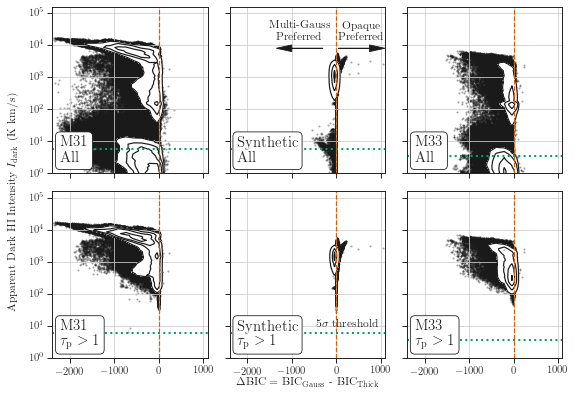

In [113]:
twocolumn_figure(font_scale=1.2)
# twocolumn_twopanel_figure()


diff_bic_m31 = m31_multigauss_bic_proj - m31_thickHI_bic_proj
diff_bic_m31_zoom = diff_bic_m31[spat_slice_zoom_m31]

valids_mask_m31 = np.logical_and(np.isfinite(diff_bic_m31), m31_ngauss > 0)

diff_bic_m33 = m33_multigauss_bic_proj - m33_thickHI_bic_proj
diff_bic_m33_zoom = diff_bic_m33[spat_slice_zoom_m33]

valids_mask_m33 = np.logical_and(np.isfinite(diff_bic_m33), m33_ngauss > 0)

taupeak_lim = 1.0
m31taupeak_mask = (m31_thickHI_hdu[0].data[2] / m31_thickHI_hdu[0].data[0]) > taupeak_lim
m33taupeak_mask = (m33_thickHI_hdu[0].data[2] / m33_thickHI_hdu[0].data[0]) > taupeak_lim

valids_mask_m31_taulim = np.logical_and(valids_mask_m31, m31taupeak_mask)
valids_mask_m33_taulim = np.logical_and(valids_mask_m33, m33taupeak_mask)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)

axs = axs.ravel()

# ranges = [(-2500, 500), (0.0, 8000.0)]
# ranges = [(-3000, 3000), (0.0, 5.2)]
ranges = [(-2400, 1100), (0.0, 5.2)]
# ranges = None

levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)
bins = [20, 100]
plot_density = False
alpha_dat = 0.4

hist2d(diff_bic_m31[valids_mask_m31 & np.isfinite(m31_darknhi_frac)],
       np.log10(m31_darknhi[valids_mask_m31 & np.isfinite(m31_darknhi_frac)] / 1000),
       ax=axs[0],
       bins=bins,
       levels=levels,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

hist2d(diff_bic_m31[valids_mask_m31_taulim & np.isfinite(m31_darknhi_frac)],
       np.log10(m31_darknhi[valids_mask_m31_taulim & np.isfinite(m31_darknhi_frac)] / 1000),
       ax=axs[3],
       bins=bins,
       levels=levels,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

hist2d(diff_bic_m33[valids_mask_m33 & np.isfinite(m33_darknhi_frac)],
       np.log10(m33_darknhi[valids_mask_m33 & np.isfinite(m33_darknhi_frac)] / 1000),
       ax=axs[2],
       bins=bins,
       levels=levels,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

hist2d(diff_bic_m33[valids_mask_m33_taulim & np.isfinite(m33_darknhi_frac)],
       np.log10(m33_darknhi[valids_mask_m33_taulim & np.isfinite(m33_darknhi_frac)] / 1000),
       ax=axs[5],
       bins=bins,
       levels=levels,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})


tab_finites = np.logical_and(np.isfinite(tab['mgauss_BIC']), np.isfinite(tab['darkint_total']))
tab_finites_taulim = np.logical_and(tab_finites, tab['Tpeak'] / tab['Ts'] > taupeak_lim)

hist2d((tab['mgauss_BIC'] - tab['thick_BIC'])[tab_finites],
       np.log10(tab['darkint_total'][tab_finites] / 1000),
       ax=axs[1],
       bins=bins,
       levels=levels,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

tab_finites = np.logical_and(np.isfinite(tab['mgauss_BIC']), np.isfinite(tab['darkint_taulim']))
tab_finites_taulim = np.logical_and(tab_finites, tab['Tpeak'] / tab['Ts'] > taupeak_lim)

hist2d((tab['mgauss_BIC'] - tab['thick_BIC'])[tab_finites_taulim],
       np.log10(tab['darkint_total'][tab_finites_taulim] / 1000),
       ax=axs[4],
       bins=bins,
       levels=levels,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

for ax in axs:
    ax.axvline(0., color='r', linestyle='--')

# M31 5-sigma integrated intensity per channel
axs[0].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)
axs[3].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)
# M33 5-sigma integrated intensity per channel
axs[2].axhline(np.log10(5 * 0.42 * 2.4 / np.sqrt(2)), color='g', linestyle=':',
               linewidth=2)
axs[5].axhline(np.log10(5 * 0.42 * 2.4 / np.sqrt(2)), color='g', linestyle=':',
               linewidth=2)
# M31 noise used for synthetic tests
axs[1].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)
axs[4].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)

[ax.grid() for ax in axs]

# axs[0].set_xscale('symlog', linthreshx=100.)

axs[4].set_xlabel(r"$\Delta {\rm BIC} = $ BIC$_{\rm Gauss}$ - BIC$_{\rm Thick}$")

# axs[0].set_ylabel("Apparent Dark HI\nIntensity (K km/s)")
fig.text(0.06, 0.5, r"Apparent Dark HI Intensity $I_{\rm dark}$ (K km/s)",
         ha='center', va='center', rotation='vertical')

axs[0].set_yticks([0, 1, 2, 3, 4, 5])
axs[0].set_yticklabels([r'10$^0$', r'10$^1$', r'10$^2$', r'10$^3$', r'10$^4$', r'10$^5$'])

# Make various text labels in the plots
# Labels
bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

xp = 0.05
yp = 0.05

axs[0].text(xp, yp, "M31\nAll", transform=axs[0].transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)
axs[2].text(xp, yp, "M33\nAll", transform=axs[2].transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)
axs[1].text(xp, yp, "Synthetic\nAll", transform=axs[1].transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)

axs[3].text(xp, yp, "M31\n$\\tau_{\\mathrm{p}} > 1$", transform=axs[3].transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)
axs[5].text(xp, yp, "M33\n$\\tau_{\\mathrm{p}} > 1$", transform=axs[5].transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)
axs[4].text(xp, yp, "Synthetic\n$\\tau_{\\mathrm{p}} > 1$", transform=axs[4].transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=15)

# BIC model preference
# axs[1].text(0.25, 0.85, "Multi-Gauss\nPreferred",
axs[1].text(0.45, 0.85, "Multi-Gauss\nPreferred",
            transform=axs[1].transAxes,
            horizontalalignment='center',
            verticalalignment='center',)
#             bbox=bbox_props)

# axs[1].arrow(0.4, 0.75, -0.2, 0.0, head_width=0.04,
axs[1].arrow(0.6, 0.75, -0.2, 0.0, head_width=0.04,
             head_length=0.1, fc='k', ec='k',
             transform=axs[1].transAxes)

# axs[1].text(0.75, 0.85, "Opaque\nPreferred",
axs[1].text(0.85, 0.85, "Opaque\nPreferred",
            transform=axs[1].transAxes,
            horizontalalignment='center',
            verticalalignment='center',)
#             bbox=bbox_props)

axs[1].arrow(0.7, 0.75, 0.2, 0.0, head_width=0.04,
             head_length=0.1, fc='k', ec='k',
             transform=axs[1].transAxes)

# Label horizontal line
# axs[1].text(-2e2, np.log10(5 * 0.42 * 2.8) - 0.2,
#             r"$5\sigma$ threshold",
#             horizontalalignment='center', verticalalignment='top')
            
# axs[1].text(-2e2, np.log10(5 * 0.42 * 2.8) - 0.2,
#             r"$5\sigma$ threshold",
#             color='w',
#             horizontalalignment='center', verticalalignment='top',
#             fontsize=13)
    
axs[4].text(9.7e2, np.log10(5 * 0.42 * 2.8) + 0.1,
            r"$5\sigma$" + " threshold",
            horizontalalignment='right', verticalalignment='bottom')
    
plt.tight_layout()
fig.subplots_adjust(left=0.125, bottom=0.125)

plot_name = 'm31_m33_synth_diffBIC_darkintint_withtaulim'

save_figure(fig, plot_name)

From this plot, compute the fraction of "missing" integrated intensity where $$\Delta {\rm BIC} > 0$$.

In [121]:
hi_mass_conversion = 0.0196 * (u.M_sun / u.pc ** 2) / (u.K * u.km / u.s)

d_m31 = 720 * u.kpc
pix_area_m31 = ((3 * u.arcsec).to(u.rad).value * d_m31).to(u.pc)**2


m31_thickHI_pref = diff_bic_m31[valids_mask_m31 & np.isfinite(m31_darknhi_frac)] > 0.
m31_missing_intint_lim = (m31_darknhi[valids_mask_m31 & np.isfinite(m31_darknhi_frac)] / 1000)[m31_thickHI_pref].sum()
m31_missing_intint_lim = m31_missing_intint_lim * u.K * u.km / u.s

m31_missing_hi_mass_lim = m31_missing_intint_lim * hi_mass_conversion * pix_area_m31

# Total mass estimate
# Moment 0
m31_total_intint = np.nansum(m31_mom0)
m31_total_optthin_mass = m31_total_intint * hi_mass_conversion * pix_area_m31


d_m33 = 840 * u.kpc
pix_area_m33 = ((3 * u.arcsec).to(u.rad).value * d_m33).to(u.pc)**2

m33_thickHI_pref = diff_bic_m33[valids_mask_m33 & np.isfinite(m33_darknhi_frac)] > 0.
m33_missing_intint_lim = (m33_darknhi[valids_mask_m33 & np.isfinite(m33_darknhi_frac)] / 1000)[m33_thickHI_pref].sum()
m33_missing_intint_lim = m33_missing_intint_lim * u.K * u.km / u.s

m33_missing_hi_mass_lim = m33_missing_intint_lim * hi_mass_conversion * pix_area_m33


m33_total_intint = np.nansum(m33_mom0)
m33_total_optthin_mass = m33_total_intint * hi_mass_conversion * pix_area_m33


In [122]:
m31_missing_hi_mass_lim

<Quantity 21479785.10713181 solMass>

In [123]:
m33_missing_hi_mass_lim

<Quantity 8826205.91275622 solMass>

In [124]:
m31_total_optthin_mass

<Projection 1.60966882e+09 solMass>

In [125]:
m33_total_optthin_mass

<Projection 1.02029634e+09 solMass>

In [141]:
print(f"% of dark HI in M33: {100 * m33_missing_hi_mass_lim / m33_total_optthin_mass}")

% of dark HI in M33: 0.8650629753396657


In [142]:
print(f"% of dark HI in M31: {100 * m31_missing_hi_mass_lim / m31_total_optthin_mass}")

% of dark HI in M31: 1.3344226348997097


In [146]:
nspec = (m31_thickHI_pref).sum()
m31_nspec_all = m31_thickHI_pref.size
print(f"% of spectra in M31 comparison: {100 * nspec / m31_nspec_all}")

% of spectra in M31 comparison: 1.6427959804592644


In [147]:
nspec = (m33_thickHI_pref).sum()
m33_nspec_all = m33_thickHI_pref.size
print(f"% of spectra in M33 comparison: {100 * nspec / m33_nspec_all}")

% of spectra in M33 comparison: 0.7700461716258619


And what would we imply the correction factor is with no model selection?

In [128]:
m31_missing_intint_all = (m31_darknhi[valids_mask_m31 & np.isfinite(m31_darknhi_frac)] / 1000).sum()
m31_missing_intint_all = m31_missing_intint_all * u.K * u.km / u.s

m31_missing_hi_mass_all = m31_missing_intint_all * hi_mass_conversion * pix_area_m31

print(f"% of dark HI in M31: {100 * m31_missing_hi_mass_all / m31_total_optthin_mass}")

% of dark HI in M31: 117.97092668084036


In [129]:
m31_missing_hi_mass_all

<Quantity 1.89894123e+09 solMass>

In [130]:
m33_missing_intint_all = (m33_darknhi[valids_mask_m33 & np.isfinite(m33_darknhi_frac)] / 1000).sum()
m33_missing_intint_all = m33_missing_intint_all * u.K * u.km / u.s

m33_missing_hi_mass_all = m33_missing_intint_all * hi_mass_conversion * pix_area_m33

print(f"% of dark HI in M33: {100 * m33_missing_hi_mass_all / m33_total_optthin_mass}")

% of dark HI in M33: 36.68981052626233


In [131]:
m33_missing_hi_mass_all

<Quantity 3.74344796e+08 solMass>

M33 looks fine. M31 has a bunch of clearly too large corrections for a population of spectra. So let's add in the red. chisq < 25 cut-off used by Braun 09,12.

% spectra with chisq < 25: 1.0
% spectra with chisq < 25: 1.0
% spectra with chisq < 1: 0.21134009578956506
% spectra with chisq < 1: 0.08157841609682112


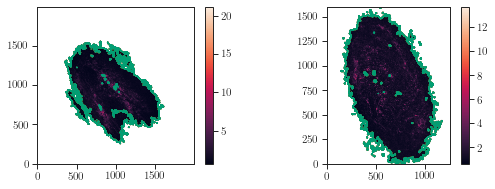

In [155]:
m31_chisq_mask = m31_thickHI_rchi_proj < 25
m33_chisq_mask = m33_thickHI_rchi_proj < 25

plt.subplot(121)
plt.imshow(m31_thickHI_rchi_proj.value, origin='lower')
plt.colorbar()
plt.contour(m31_chisq_mask, colors='r')
plt.contour(m31_thickHI_rchi_proj < 10., colors='g')
plt.subplot(122)
plt.imshow(m33_thickHI_rchi_proj.value, origin='lower')
plt.colorbar()
plt.contour(m33_chisq_mask, colors='r')
plt.contour(m33_thickHI_rchi_proj < 10., colors='g')

print(f"% spectra with chisq < 25: {m31_chisq_mask.sum() / np.isfinite(m31_thickHI_rchi_proj).sum()}")
print(f"% spectra with chisq < 25: {m33_chisq_mask.sum() / np.isfinite(m33_thickHI_rchi_proj).sum()}")

print(f"% spectra with chisq < 1: {(m31_thickHI_rchi_proj < 1.).sum() / np.isfinite(m31_thickHI_rchi_proj).sum()}")
print(f"% spectra with chisq < 1: {(m33_thickHI_rchi_proj < 1.).sum() / np.isfinite(m33_thickHI_rchi_proj).sum()}")


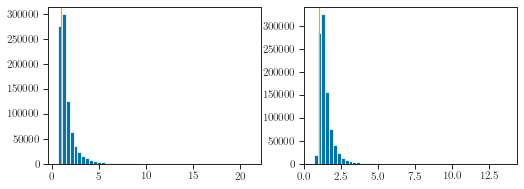

In [158]:
plt.subplot(121)
_ = plt.hist(m31_thickHI_rchi_proj.value[np.isfinite(m31_thickHI_rchi_proj.value)], bins=50)
plt.axvline(1., color='orange')
plt.subplot(122)
_ = plt.hist(m33_thickHI_rchi_proj.value[np.isfinite(m33_thickHI_rchi_proj.value)], bins=50)
plt.axvline(1., color='orange')


Conclusion: The reduced chisq cut-off used in Braun 2009/2012 does not provide any measure of poor fits when used with our new data.

Add plot of inferred mass correction as function of reduced chi sq.

Several of the taus are very large and likely not physical. What is the mass correction if we remove all LOS with peak tau >3?

In [176]:
# This would be better as a plot... choosing 8 as the demonstration value for the table just for now

taupeak_lim_high = 8.0
m31taupeak_mask = (m31_thickHI_hdu[0].data[2] / m31_thickHI_hdu[0].data[0]) < taupeak_lim_high
m33taupeak_mask = (m33_thickHI_hdu[0].data[2] / m33_thickHI_hdu[0].data[0]) < taupeak_lim_high


In [180]:
m31_missing_intint_taulim = (m31_darknhi[m31taupeak_mask & np.isfinite(m31_darknhi_frac)] / 1000).sum()
m31_missing_intint_taulim = m31_missing_intint_taulim * u.K * u.km / u.s

m31_missing_hi_mass_taulim = m31_missing_intint_taulim * hi_mass_conversion * pix_area_m31

print(f"Dark HI Mass: {m31_missing_hi_mass_taulim}")
print(f"% of dark HI in M31 with peak tau < 3: {100 * m31_missing_hi_mass_taulim / m31_total_optthin_mass}")
print(f"% of spectra {100 * (m31taupeak_mask & np.isfinite(m31_darknhi_frac)).sum() / np.isfinite(m31_darknhi).sum()}")

Dark HI Mass: 601008620.0828623 solMass
% of dark HI in M31 with peak tau < 3: 37.33740828450505
% of spectra 90.31756641751761


In [181]:
m33_missing_intint_taulim = (m33_darknhi[m33taupeak_mask & np.isfinite(m33_darknhi_frac)] / 1000).sum()
m33_missing_intint_taulim = m33_missing_intint_taulim * u.K * u.km / u.s

m33_missing_hi_mass_taulim = m33_missing_intint_taulim * hi_mass_conversion * pix_area_m33

print(f"Dark HI Mass: {m33_missing_hi_mass_taulim}")
print(f"% of dark HI in M33 with peak tau < 3: {100 * m33_missing_hi_mass_taulim / m33_total_optthin_mass}")
print(f"% of spectra {100 * (m33taupeak_mask & np.isfinite(m33_darknhi_frac)).sum() / np.isfinite(m33_darknhi).sum()}")

Dark HI Mass: 312445613.41491485 solMass
% of dark HI in M33 with peak tau < 3: 30.623025866856228
% of spectra 99.19743660090796


Make BIC maps. Two panel figure

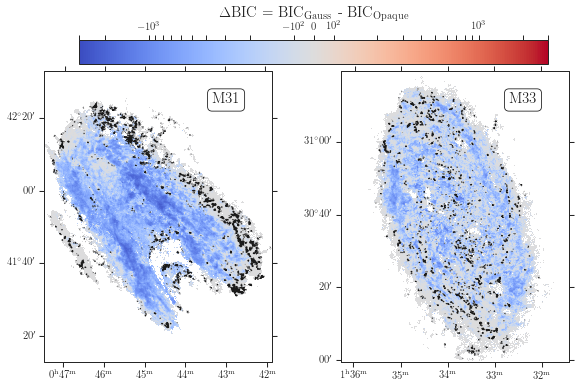

In [25]:
twocolumn_figure(font_scale=1.2)

import matplotlib.colors as colors

vmin = -3000
vmax = 3000

norm = colors.SymLogNorm(linthresh=100., linscale=0.2,
                         vmin=vmin, vmax=vmax)

fig = plt.figure()

diff_bic_zoom_m31 = diff_bic_m31[spat_slice_zoom_m31]

ax = fig.add_subplot(121, projection=diff_bic_zoom_m31.wcs)

im = ax.imshow(diff_bic_zoom_m31.value, # vmin=vmin, vmax=vmax,
               norm=norm,
               cmap=plt.cm.coolwarm)
#                cmap=plt.cm.Oranges_r)

ax.contour(diff_bic_zoom_m31.value, levels=[0], colors='k')

diff_bic_zoom_m33 = diff_bic_m33[spat_slice_zoom_m33]

ax2 = fig.add_subplot(122, projection=diff_bic_zoom_m33.wcs)

# Scale to the 95% in image
# vmin, vmax = np.nanpercentile(diff_bic_zoom_m33, [2.5, 97.5])

im2 = ax2.imshow(diff_bic_zoom_m33.value, # vmin=vmin, vmax=vmax,
                 norm=norm,
                 cmap=plt.cm.coolwarm)
#                  cmap=plt.cm.Oranges_r)

ax2.contour(diff_bic_zoom_m33.value, levels=[0], colors='k')

# cbar = plt.colorbar(im2)
cbar = fig.colorbar(im, ax=[ax, ax2], location='top')

cbar.set_label(r"$\Delta$BIC = BIC$_{\rm Gauss}$ - BIC$_{\rm Opaque}$", fontsize=15)

xp = 0.8
yp = 0.9

ax.text(xp, yp, "M31", transform=ax.transAxes,
        horizontalalignment='center',
        verticalalignment='center',
        bbox=bbox_props, fontsize=15)

ax2.text(xp, yp, "M33", transform=ax2.transAxes,
         horizontalalignment='center',
         verticalalignment='center',
         bbox=bbox_props, fontsize=15)

# plt.tight_layout()

fig.subplots_adjust(right=0.95, left=0.05, bottom=0.05, top=0.75)

save_figure(fig, 'm31_m33_delta_bic_map')


In [26]:
print(diff_bic_zoom_m31.shape, diff_bic_zoom_m33.shape)

(1604, 1256) (1604, 1256)


Make a figure of the tau limited BIC comparisons only.

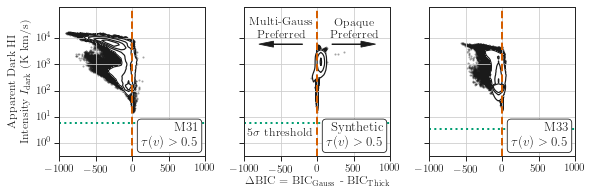

In [107]:
# twocolumn_figure()
twocolumn_twopanel_figure()


diff_bic_m31_taulim = m31_modcompare_hdu[1].data - m31_modcompare_hdu[0].data
darknhi_m31_taulim = m31_modcompare_hdu[6].data

# valids_mask_m31 = np.logical_and(np.isfinite(diff_bic_m31_taulim), m31_ngauss > 0)
valids_mask_m31 = np.isfinite(diff_bic_m31_taulim)

diff_bic_m33_taulim = m33_modcompare_hdu[1].data - m33_modcompare_hdu[0].data
darknhi_m33_taulim = m33_modcompare_hdu[6].data

# valids_mask_m33 = np.logical_and(np.isfinite(diff_bic_m33), m33_ngauss > 0)
valids_mask_m33 = np.isfinite(diff_bic_m33)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

# ranges = [(-2500, 500), (0.0, 8000.0)]
# ranges = [(-3000, 3000), (0.0, 5.2)]
ranges = [(-1000, 1000), (-0.5, 5.2)]
# ranges = None

plot_density = False
bins = [20, 100]
alpha_dat = 0.4

hist2d(diff_bic_m31_taulim[valids_mask_m31 & np.isfinite(darknhi_m31_taulim)],
       np.log10(m31_darknhi[valids_mask_m31 & np.isfinite(darknhi_m31_taulim)] / 1000),
       ax=axs[0],
       bins=bins,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

hist2d(diff_bic_m33_taulim[valids_mask_m33 & np.isfinite(darknhi_m33_taulim)],
       np.log10(m33_darknhi[valids_mask_m33 & np.isfinite(darknhi_m33_taulim)] / 1000),
       ax=axs[2],
       bins=bins,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

tab_finites = np.logical_and(np.isfinite(tab['mgauss_BIC']), np.isfinite(tab['darkint_taulim']))
hist2d((tab['mgauss_BIC_taulim'] - tab['thick_BIC_taulim'])[tab_finites],
       np.log10(tab['darkint_taulim'][tab_finites] / 1000),
       ax=axs[1],
       bins=bins,
       plot_density=plot_density,
       range=ranges,
       data_kwargs={"alpha": alpha_dat})

axs[0].axvline(0., color='r', linestyle='--', linewidth=2)
axs[1].axvline(0., color='r', linestyle='--', linewidth=2)
axs[2].axvline(0., color='r', linestyle='--', linewidth=2)

# M31 5-sigma integrated intensity per channel
axs[0].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)
# M33 5-sigma integrated intensity per channel
axs[2].axhline(np.log10(5 * 0.42 * 2.4 / np.sqrt(2)), color='g', linestyle=':', linewidth=2)
# M31 noise used for synthetic tests
axs[1].axhline(np.log10(5 * 0.42 * 2.8), color='g', linestyle=':', linewidth=2)

[ax.grid() for ax in axs]

# axs[0].set_xscale('symlog', linthreshx=100.)

axs[1].set_xlabel(r"$\Delta {\rm BIC} = $ BIC$_{\rm Gauss}$ - BIC$_{\rm Thick}$")
axs[0].set_ylabel("Apparent Dark HI\n" + r"Intensity $I_{\rm dark}$ (K km/s)")

axs[0].set_yticks([0, 1, 2, 3, 4])
axs[0].set_yticklabels([r'10$^0$', r'10$^1$', r'10$^2$', r'10$^3$', r'10$^4$'])

# Make various text labels in the plots
# Labels
bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

xp = 0.95
yp = 0.05

axs[0].text(xp, yp, "M31\n" + r"$\tau(v) > 0.5$",
            transform=axs[0].transAxes,
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=13)
axs[2].text(xp, yp, "M33\n" + r"$\tau(v) > 0.5$",
            transform=axs[2].transAxes,
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=13)
axs[1].text(xp, yp, "Synthetic\n" + r"$\tau(v) > 0.5$",
            transform=axs[1].transAxes,
            horizontalalignment='right',
            verticalalignment='bottom',
            bbox=bbox_props, fontsize=13)

# BIC model preference
axs[1].text(0.25, 0.85, "Multi-Gauss\nPreferred",
            transform=axs[1].transAxes,
            horizontalalignment='center',
            verticalalignment='center',)
#             bbox=bbox_props)

axs[1].arrow(0.4, 0.75, -0.2, 0.0, head_width=0.04,
             head_length=0.1, fc='k', ec='k',
             transform=axs[1].transAxes)

axs[1].text(0.75, 0.85, "Opaque\nPreferred",
            transform=axs[1].transAxes,
            horizontalalignment='center',
            verticalalignment='center',)
#             bbox=bbox_props)

axs[1].arrow(0.6, 0.75, 0.2, 0.0, head_width=0.04,
             head_length=0.1, fc='k', ec='k',
             transform=axs[1].transAxes)

# Label horizontal line
axs[1].text(-9.65e2, np.log10(5 * 0.42 * 2.8) - 0.2,
            r"$5\sigma$ threshold",
            horizontalalignment='left', verticalalignment='top')
            
#             bbox=bbox_props)

plt.tight_layout()

plot_name = 'm31_m33_synth_diffBIC_darkintint_taulim_only'

save_figure(fig, plot_name)


Calculate fraction of spectra preferred in different categories: (i) Delta BIC < -10; (ii) -10 > Delta BIC < 10; and (iii) Delta BIC > 10. Include the synthetic comparison.

In [44]:
m31_frac_i = (diff_bic_m31 < -10).sum() / np.isfinite(diff_bic_m31).sum()
m31_frac_ii = np.logical_and(diff_bic_m31 > -10, diff_bic_m31 < 10).sum() / np.isfinite(diff_bic_m31).sum()
m31_frac_iii = (diff_bic_m31 > 10).sum() / np.isfinite(diff_bic_m31).sum()

print(f"M31 fracs (i): {m31_frac_i}; (ii): {m31_frac_ii}; (iii): {m31_frac_iii}")
print(f"Sanity sum check: {m31_frac_i + m31_frac_ii + m31_frac_iii}")

M31 fracs (i): 0.8198106050254604; (ii): 0.17515326366034353; (iii): 0.005036131314196035
Sanity sum check: 1.0


In [49]:
m33_frac_i = (diff_bic_m33 < -10).sum() / np.isfinite(diff_bic_m33).sum()
m33_frac_ii = np.logical_and(diff_bic_m33 > -10, diff_bic_m33 < 10).sum() / np.isfinite(diff_bic_m33).sum()
m33_frac_iii = (diff_bic_m33 > 10).sum() / np.isfinite(diff_bic_m33).sum()

print(f"M33 fracs (i): {m33_frac_i}; (ii): {m33_frac_ii}; (iii): {m33_frac_iii}")
print(f"Sanity sum check: {m33_frac_i + m33_frac_ii + m33_frac_iii}")

M33 fracs (i): 0.8024452831196046; (ii): 0.1961042760197856; (iii): 0.0014504408606097413
Sanity sum check: 1.0


In [56]:
# tab_finites = np.logical_and(np.isfinite(tab['mgauss_BIC']), np.isfinite(tab['darkint_total']))

synth_bic_diff = tab['mgauss_BIC'] - tab['thick_BIC']
tab_finites = np.isfinite(synth_bic_diff)

synth_frac_i = (synth_bic_diff < -10).sum() / tab_finites.sum()
synth_frac_ii = np.logical_and(synth_bic_diff > -10, synth_bic_diff < 10).sum() / tab_finites.sum()
synth_frac_iii = (synth_bic_diff > 10).sum() / tab_finites.sum()

print(f"Synth fracs (i): {synth_frac_i}; (ii): {synth_frac_ii}; (iii): {synth_frac_iii}")
print(f"Sanity sum check: {synth_frac_i + synth_frac_ii + synth_frac_iii}")

0.01003119735429944
Synth fracs (i): 0.010925382388383593; (ii): 0.49892746246118613; (iii): 0.4901471551504303
Sanity sum check: 1.0


Same comparison, only for lines-of-sight with apparent opaque HI (tau_peak > 1)

In [51]:
taupeak_lim = 1.0
thickmask = (m31_thickHI_hdu[0].data[2] / m31_thickHI_hdu[0].data[0]) > taupeak_lim

m31_frac_i = (diff_bic_m31[thickmask] < -10).sum() / np.isfinite(diff_bic_m31[thickmask]).sum()
m31_frac_ii = np.logical_and(diff_bic_m31[thickmask] > -10, diff_bic_m31[thickmask] < 10).sum() / \
    np.isfinite(diff_bic_m31[thickmask]).sum()
m31_frac_iii = (diff_bic_m31[thickmask] > 10).sum() / np.isfinite(diff_bic_m31[thickmask]).sum()

print(f"M31 fracs (i): {m31_frac_i}; (ii): {m31_frac_ii}; (iii): {m31_frac_iii}")
print(f"Sanity sum check: {m31_frac_i + m31_frac_ii + m31_frac_iii}")

M31 fracs (i): 0.8868447317850705; (ii): 0.10477836205912; (iii): 0.00837690615580946
Sanity sum check: 1.0


In [52]:
thickmask = (m33_thickHI_hdu[0].data[2] / m33_thickHI_hdu[0].data[0]) > taupeak_lim

m33_frac_i = (diff_bic_m33[thickmask] < -10).sum() / np.isfinite(diff_bic_m33[thickmask]).sum()
m33_frac_ii = np.logical_and(diff_bic_m33[thickmask] > -10, diff_bic_m33[thickmask] < 10).sum() / \
    np.isfinite(diff_bic_m33[thickmask]).sum()
m33_frac_iii = (diff_bic_m33[thickmask] > 10).sum() / np.isfinite(diff_bic_m33[thickmask]).sum()

print(f"M33 fracs (i): {m33_frac_i}; (ii): {m33_frac_ii}; (iii): {m33_frac_iii}")
print(f"Sanity sum check: {m33_frac_i + m33_frac_ii + m33_frac_iii}")

M33 fracs (i): 0.8323621901590825; (ii): 0.1602663706992231; (iii): 0.007371439141694414
Sanity sum check: 1.0


In [58]:
thickmask = tab['Tpeak'] / tab['Ts'] > taupeak_lim

synth_bic_diff = tab['mgauss_BIC'] - tab['thick_BIC']
tab_finites = np.logical_and(np.isfinite(synth_bic_diff), thickmask)

synth_frac_i = (synth_bic_diff[tab_finites] < -10).sum() / tab_finites.sum()
synth_frac_ii = np.logical_and(synth_bic_diff[tab_finites] > -10, synth_bic_diff[tab_finites] < 10).sum() / tab_finites.sum()
synth_frac_iii = (synth_bic_diff[tab_finites] > 10).sum() / tab_finites.sum()

print(f"Synth fracs (i): {synth_frac_i}; (ii): {synth_frac_ii}; (iii): {synth_frac_iii}")
print(f"Sanity sum check: {synth_frac_i + synth_frac_ii + synth_frac_iii}")

Synth fracs (i): 0.014447372965991604; (ii): 0.35016857771470195; (iii): 0.6353840493193065
Sanity sum check: 1.0


(iii) only where inferred tau > 0.5, recomputed only over that range in channels.

In [68]:
m31_diff_bics_masked = diff_bic_m31_taulim[valids_mask_m31 & np.isfinite(darknhi_m31_taulim)]

m31_frac_i = (m31_diff_bics_masked < -10).sum() / np.isfinite(m31_diff_bics_masked).sum()
m31_frac_ii = np.logical_and(m31_diff_bics_masked > -10, m31_diff_bics_masked < 10).sum() / np.isfinite(m31_diff_bics_masked).sum()
m31_frac_iii = (m31_diff_bics_masked > 10).sum() / np.isfinite(m31_diff_bics_masked).sum()

print(f"M31 fracs (i): {m31_frac_i}; (ii): {m31_frac_ii}; (iii): {m31_frac_iii}")
print(f"Sanity sum check: {m31_frac_i + m31_frac_ii + m31_frac_iii}")

M31 fracs (i): 0.836609891757432; (ii): 0.1539299696346444; (iii): 0.009460138607923711
Sanity sum check: 1.0


In [69]:
m33_diff_bics_masked = diff_bic_m33_taulim[valids_mask_m33 & np.isfinite(darknhi_m33_taulim)]

m33_frac_i = (m33_diff_bics_masked < -10).sum() / np.isfinite(m33_diff_bics_masked).sum()
m33_frac_ii = np.logical_and(m33_diff_bics_masked > -10, m33_diff_bics_masked < 10).sum() / np.isfinite(m33_diff_bics_masked).sum()
m33_frac_iii = (m33_diff_bics_masked > 10).sum() / np.isfinite(m33_diff_bics_masked).sum()

print(f"M33 fracs (i): {m33_frac_i}; (ii): {m33_frac_ii}; (iii): {m33_frac_iii}")
print(f"Sanity sum check: {m33_frac_i + m33_frac_ii + m33_frac_iii}")

M33 fracs (i): 0.7441272516591172; (ii): 0.24984614702245977; (iii): 0.006026601318422993
Sanity sum check: 1.0


In [70]:
synth_bic_diff = tab['mgauss_BIC_taulim'] - tab['thick_BIC_taulim']
tab_finites = np.isfinite(synth_bic_diff)

synth_frac_i = (synth_bic_diff[tab_finites] < -10).sum() / tab_finites.sum()
synth_frac_ii = np.logical_and(synth_bic_diff[tab_finites] > -10, synth_bic_diff[tab_finites] < 10).sum() / tab_finites.sum()
synth_frac_iii = (synth_bic_diff[tab_finites] > 10).sum() / tab_finites.sum()

print(f"Synth fracs (i): {synth_frac_i}; (ii): {synth_frac_ii}; (iii): {synth_frac_iii}")
print(f"Sanity sum check: {synth_frac_i + synth_frac_ii + synth_frac_iii}")

Synth fracs (i): 0.0057321232868278145; (ii): 0.7853747737319755; (iii): 0.20889310298119668
Sanity sum check: 1.0
